In [1]:
import os
from nilearn import image as nimg
from nilearn import plotting as nplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
serv = "/../Volumes/project/Hanson/"
fold = "Internal_MRI_Projects/CEDAR_MRI/Projects/nilearn_test/new_download"

In [5]:
os.listdir(serv+fold)

['0223', '0397', '0366', '0709', '0241', '0268', '0350', '0299', '0256', '0344', '0445', '0282', '0367', '0373', '0403', '0342', '0302', 'mask_temp.json', '0322', '0284', '0301', '0399', '0245', '0688', '0270', '0406', '0315', '0307', '0205', '0425', '.DS_Store', '0449', '0354', 'regressors.json', '0353', '0230', '0247', '0584', '0372', '0416', '0358', '0234', '0236', '0254', '0386', '0427', '0541', '0390', '0335', '0261', '0357', '0273', '0465', '0321', 'mask_to_save.json', '0300', '0370', 'func_to_save.json', '0378', '0246', '0214', '0298', '0211', '0363', '0310', '0340', '0202', '0260', '0212', '0278', '0216', '0228', '0338', '0265', '0297', '0222', '0381', '0396', '0306', '0377', '0317', '0400', '0410', '0371', '0232', '0343', '0359', '0281', '0419', '0629', '0240', '0248', '0227', 'func_temp.json', '0219', '0393', '0392', '0210', '0365', '0374']

In [6]:
def clean_img_dataloader(folder, subject):
    """
    Locate the required data to run nilearn.image.clean_img.
    Returns full filepaths for regressor file, functional image file, 
    and mask image file (if present). Technically not a data loader.
    
    folder and subject must be valid directories. 
    
    subject must contain files titled:
        regressors.tsv
        bold.nii.gz
    subject may optionally contain a file titled:
        mask.nii.gz
    """
    confounds = ""
    func = ""
    mask = ""
    
    for root,dirs,files in os.walk(folder + "/" + subject):
        for f in files:
            if "regressors.tsv" in f: 
                confounds+=(os.path.join(root, f))
            if "bold.nii.gz" in f: 
                func+=(os.path.join(root, f))
            if "mask.nii.gz" in f: 
                mask+=(os.path.join(root, f))
    
    if mask == "":
        return confounds, func
    
    else:
        return confounds, func, mask

In [7]:
def clean_img_prepdata(confounds, func, mask = None, derivatives = True, drop = 4,
                  confound_vars = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z',
                                   'global_signal','csf', 'white_matter']):
    """
    Loads and prepares data for running through nilearn.image.clean_img.
    Returns confound matrix, functional image, and mask image (if present).
    
    derivatives is True by default. disable to reduce # of confound variables.
    
    drop is 4 by default. drops the first n timepoints from the data.
    
    confound_vars defaults to ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z',
                                   'global_signal','csf', 'white_matter'].
    if different confound_vars desired, they must be formatted as a list of strings. 
    strings must be valid column names in confounds file.
    
    """
    # prepare confounds
    confound_df = pd.read_csv(confounds, delimiter='\t')
    final_confounds = confound_vars
    
    if derivatives==True:
        final_confounds.extend(['trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 
                                'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1',
                                'global_signal_derivative1','csf_derivative1','white_matter_derivative1'])
    
    confound_matrix = confound_df[final_confounds].loc[drop:].values
    
    raw_func_img = nimg.load_img(func)
    func_img = raw_func_img.slicer[:,:,:,drop:]
    
    if mask:
        mask_img = nimg.load_img(mask)
        return confound_matrix, func_img, mask_img
    
    else:
        return confound_matrix, func_img

In [8]:
def clean_img_batchload(folder, subj_list):
    """
    Locates, loads, and prepares data for running through nilearn.image.clean_img.
    Returns list containing tuples of confound matrix, functional image, and mask image (if present).
    """
    tup_list= []
    for e, s in tqdm(enumerate(subj_list)):
        c, f, m = clean_img_dataloader(folder, s)
        c_m, f_i, m_i = clean_img_prepdata(c, f, m)
        tup_list.append((c_m, f_i, m_i))
        #print(str(e+1)+ "/" + str(len(subj_list)) + " complete...")
        
    return tup_list

In [9]:
subj_folds = [x for x in os.listdir(serv+fold) if "." not in x]
chunked_subj_folds = [subj_folds[i:i+10] for i in range(0, len(subj_folds), 10)]

In [10]:
chunked_subj_folds

[['0223', '0397', '0366', '0709', '0241', '0268', '0350', '0299', '0256', '0344'], ['0445', '0282', '0367', '0373', '0403', '0342', '0302', '0322', '0284', '0301'], ['0399', '0245', '0688', '0270', '0406', '0315', '0307', '0205', '0425', '0449'], ['0354', '0353', '0230', '0247', '0584', '0372', '0416', '0358', '0234', '0236'], ['0254', '0386', '0427', '0541', '0390', '0335', '0261', '0357', '0273', '0465'], ['0321', '0300', '0370', '0378', '0246', '0214', '0298', '0211', '0363', '0310'], ['0340', '0202', '0260', '0212', '0278', '0216', '0228', '0338', '0265', '0297'], ['0222', '0381', '0396', '0306', '0377', '0317', '0400', '0410', '0371', '0232'], ['0343', '0359', '0281', '0419', '0629', '0240', '0248', '0227', '0219', '0393'], ['0392', '0210', '0365', '0374']]

In [22]:
subj_tups = clean_img_batchload(serv+fold, [x for x in os.listdir(serv+fold) if "." not in x])

59it [28:27, 28.94s/it]


OSError: [Errno 6] Device not configured

In [ ]:
import pickle
pickle.dump(subj_tups, open("../files/CEDAR_processed.p", "wb"))

In [16]:
high_pass= 0.009
low_pass = 0.08
t_r = 2

clean_img_0205 = nimg.clean_img(func_img_0205,confounds=confound_matrix_0205,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask_img_0205)

clean_img_0202 = nimg.clean_img(func_img_0202,confounds=confound_matrix_0202,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask_img_0202)

In [17]:
clean_img_0205.shape

(97, 115, 97, 123)

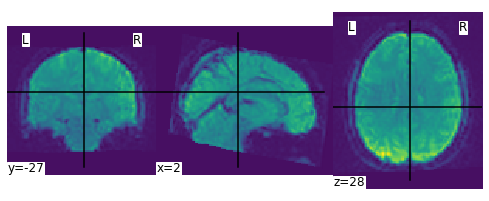

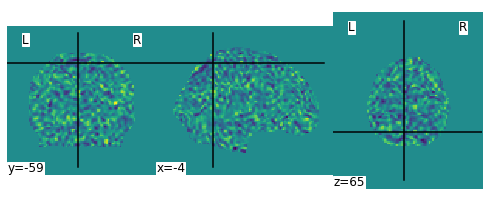

In [18]:
nplot.plot_img(func_img_0205.slicer[:,:,:,50])
nplot.plot_img(clean_img_0205.slicer[:,:,:,50])

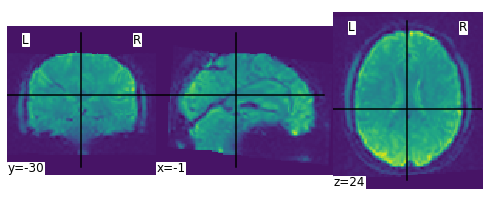

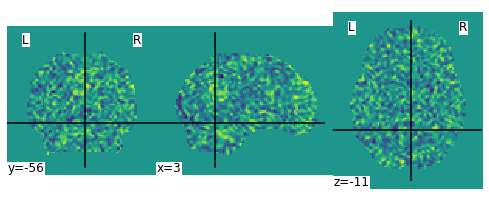

In [19]:
nplot.plot_img(func_img_0202.slicer[:,:,:,50])
nplot.plot_img(clean_img_0202.slicer[:,:,:,50])

In [18]:
# testing parcellations

from nilearn import datasets

In [19]:
# parcel_dir = '../files/'
# atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)

In [20]:
# atlas_yeo = atlas_yeo_2011['thick_7']

# from nilearn.regions import connected_label_regions

# region_labels = connected_label_regions(atlas_yeo)
# region_labels.to_filename('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


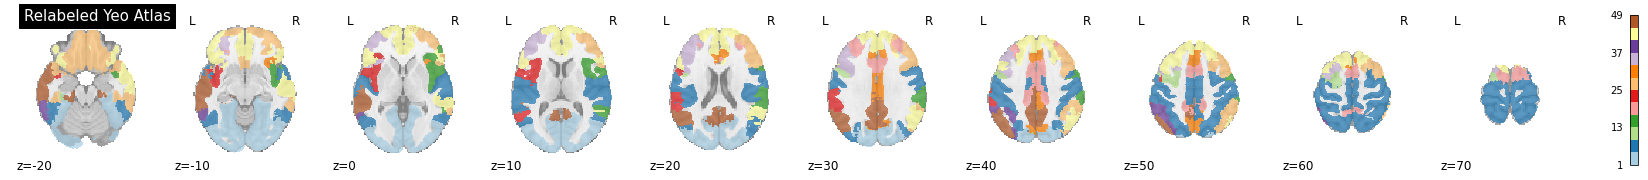

In [21]:
yeo_7 = nimg.load_img('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')
nplot.plot_roi(yeo_7, cut_coords=(-20,-10,0,10,20,30,40,50,60,70), display_mode='z',
               colorbar=True, cmap='Paired', title='Relabeled Yeo Atlas')

In [23]:
type(subj_tups)

NoneType

In [26]:
print('Size of functional image:', subj_tups[0][1].shape)
print('Size of atlas image:', yeo_7.shape)

Size of functional image: (97, 115, 97, 124)
Size of atlas image: (256, 256, 256)


In [27]:
resampled_yeo = nimg.resample_to_img(yeo_7, subj_tups[0][1], interpolation = 'nearest')

In [28]:
print('Size of resized atlas image:', resampled_yeo.shape)

Size of resized atlas image: (97, 115, 97)


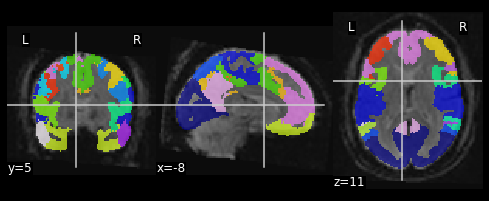

In [29]:
nplot.plot_roi(resampled_yeo, subj_tups[0][1].slicer[:, :, :, 50])

In [31]:
# functional connectivity analysis
from nilearn import maskers

In [32]:
# if i leave out mask img it should be able to be used on any scan??? according to the tutorial
masker = maskers.NiftiLabelsMasker(labels_img=yeo_7, standardize=True, 
                                   memory='nilearn_cache', verbose=1, detrend=True, 
                                   low_pass = 0.08, high_pass = 0.009, t_r=2)

In [33]:
masked_imgs = []
for (confound_matrix, func, mask) in subj_tups:
    masked = masker.fit_transform(func, confounds = confound_matrix)
    masked_imgs.append(masked)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')
Resampling labels


/Users/eva/opt/anaconda3/lib/python3.8/site-packages/nilearn/maskers/nifti_labels_masker.py:462: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 3}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f81798e7190>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f884a438340>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f884a438a60>,
  'low_pass': 0.08,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=[ array([[-5.983000e-02, ..., -1.759886e+00],
       ...,
       [-1.694040e-03, ..., -2.027618e+00]])], sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=1)
[NiftiLabelsMasker.transform_single_imgs]

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/nilearn/maskers/nifti_labels_masker.py:492: UserWarning: Persisting input arguments took 3.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


_______________________________________________filter_and_extract - 8.3s, 0.1min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f817991b160>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f8179f72f40>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f884a438a60>,
  'low_pass': 0.08,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=[ array([[0.040897, ..., 0.008795],
       ...,
       [

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/nilearn/maskers/nifti_labels_masker.py:492: UserWarning: Persisting input arguments took 3.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


_______________________________________________filter_and_extract - 8.2s, 0.1min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f8178a339a0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f8179f81970>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f884a438a60>,
  'low_pass': 0.08,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=[ array([[-0.009677, ...,  5.977723],
       ...,
      

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/nilearn/maskers/nifti_labels_masker.py:492: UserWarning: Persisting input arguments took 3.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


_______________________________________________filter_and_extract - 9.5s, 0.2min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../files/yeo_2011/relabeled_yeo_atlas.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f8178a09a60>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f884a438340>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f884a438a60>,
  'low_pass': 0.08,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=[ array([[-0.012317, ..., -0.241278],
       ...,
      

In [34]:
print(masker.labels_)
print("Number of labels", len(masker.labels_))

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]
Number of labels 47


In [35]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

In [37]:
import seaborn as sns

In [36]:
correlation_matrix_all = correlation_measure.fit_transform(masked_imgs)

Text(0.5, 1.0, '10 subjects')

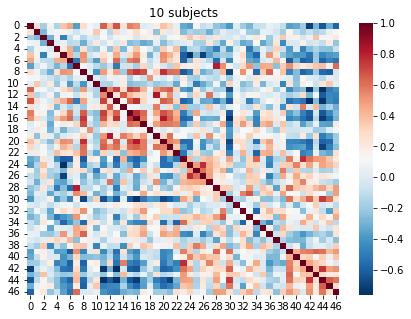

In [57]:
plt.figure(figsize=(7,5))
sns.heatmap(correlation_matrix_all[0], cmap='RdBu_r')
plt.title("10 subjects")

In [45]:
correlation_matrix_1 = correlation_measure.fit_transform(masked_imgs[:5])
correlation_matrix_2 = correlation_measure.fit_transform(masked_imgs[5:])

Text(0.5, 1.0, 'last 5 subj')

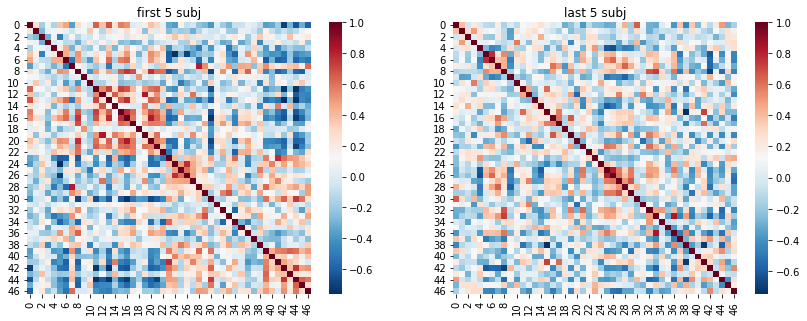

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
sns.heatmap(correlation_matrix_1[0], cmap='RdBu_r', ax=axs[0])
axs[0].set_title("first 5 subj")
sns.heatmap(correlation_matrix_2[0], cmap='RdBu_r', ax=axs[1])
axs[1].set_title("last 5 subj")